In [1]:
import os
import sys

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import s3fs
import gcsfs
import boto3



import matplotlib
import matplotlib.pyplot as plt

import itertools
from functools import partial

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
dask_client = Client()
dask_client

<Client: 'tcp://127.0.0.1:46317' processes=4 threads=8, memory=33.45 GB>

# Compute TPC across regions

In [3]:
# Load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')
# Slice to PNW
PNW_LAT = slice(30, 60)
PNW_LON = slice(-155.9, -120.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).compute()
# Load MHWs
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/new_with_climatology", s3=awsfs)
mhws = xr.open_zarr(mhw_mapper, consolidated=True)

In [4]:
mhws = xr.open_zarr(mhw_mapper, consolidated=True)
mhws = mhws.chunk({
    'lat': 100, 
    'lon' : 100, 
    'time': 500
})

In [5]:
mhws.mhw.data

dask.array<rechunk-merge, shape=(120, 140, 13636), dtype=float64, chunksize=(100, 100, 500), chunktype=numpy.ndarray>

## Choose a Region

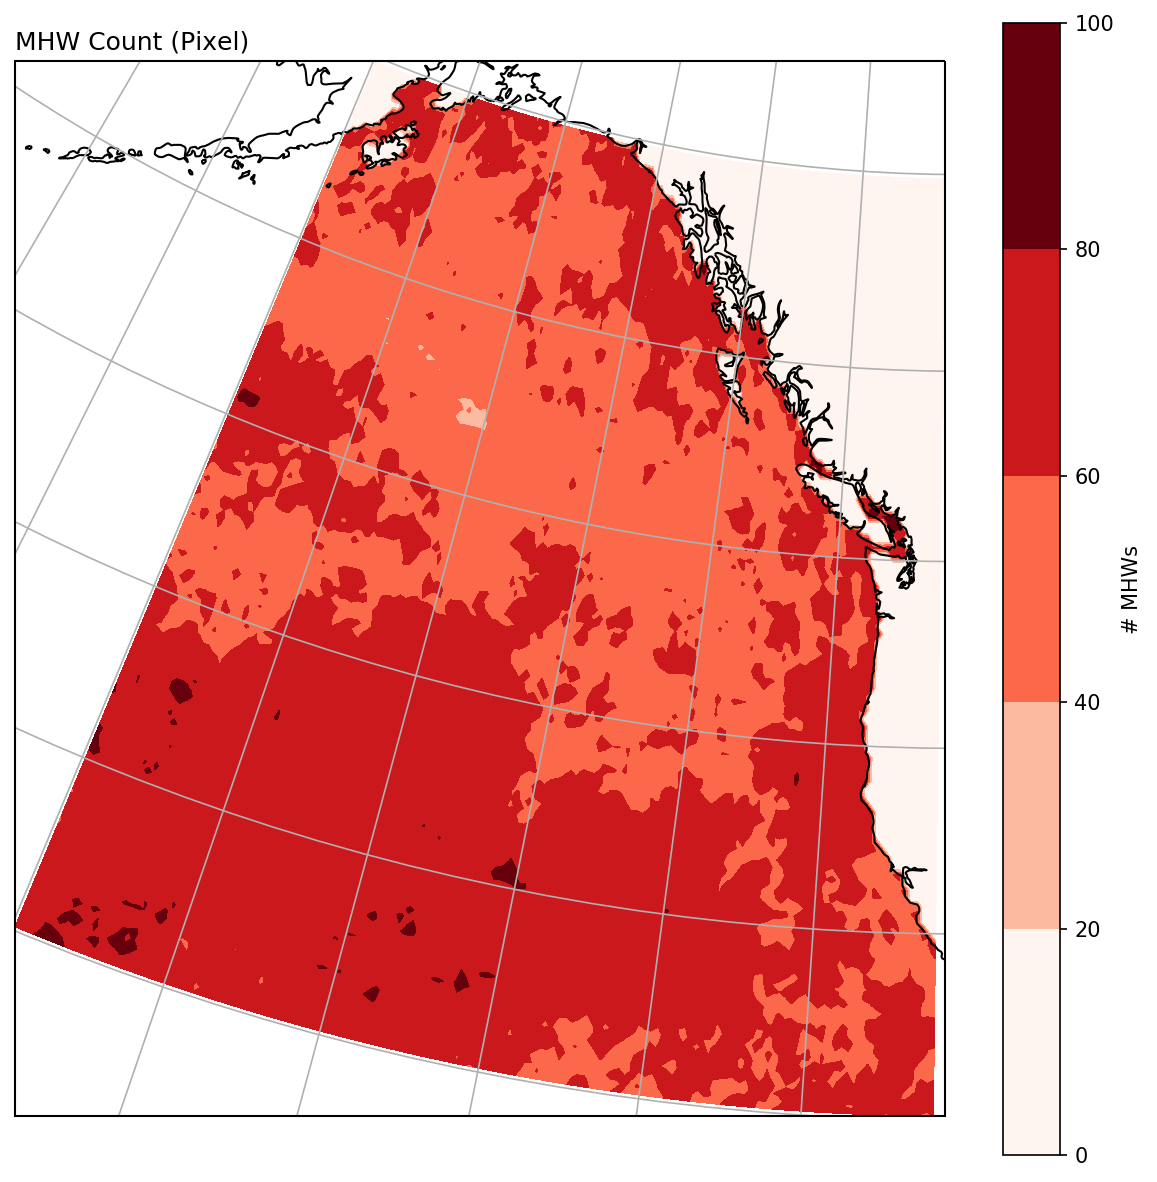

In [20]:
fig = plt.figure(figsize=(10,10), dpi=150)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-120))
mhws.mhw.max(dim='time').plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(),
    cbar_kwargs={'label' : "# MHWs"},
    cmap=plt.cm.Reds
)
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k')
ax.set_title("MHW Count (Pixel)", loc='left')
ax.gridlines()

## MHWs/year Recently

In [6]:
mhws = mhws.persist()

In [7]:
decade = mhws.sel(time=slice('1980', '1990'))

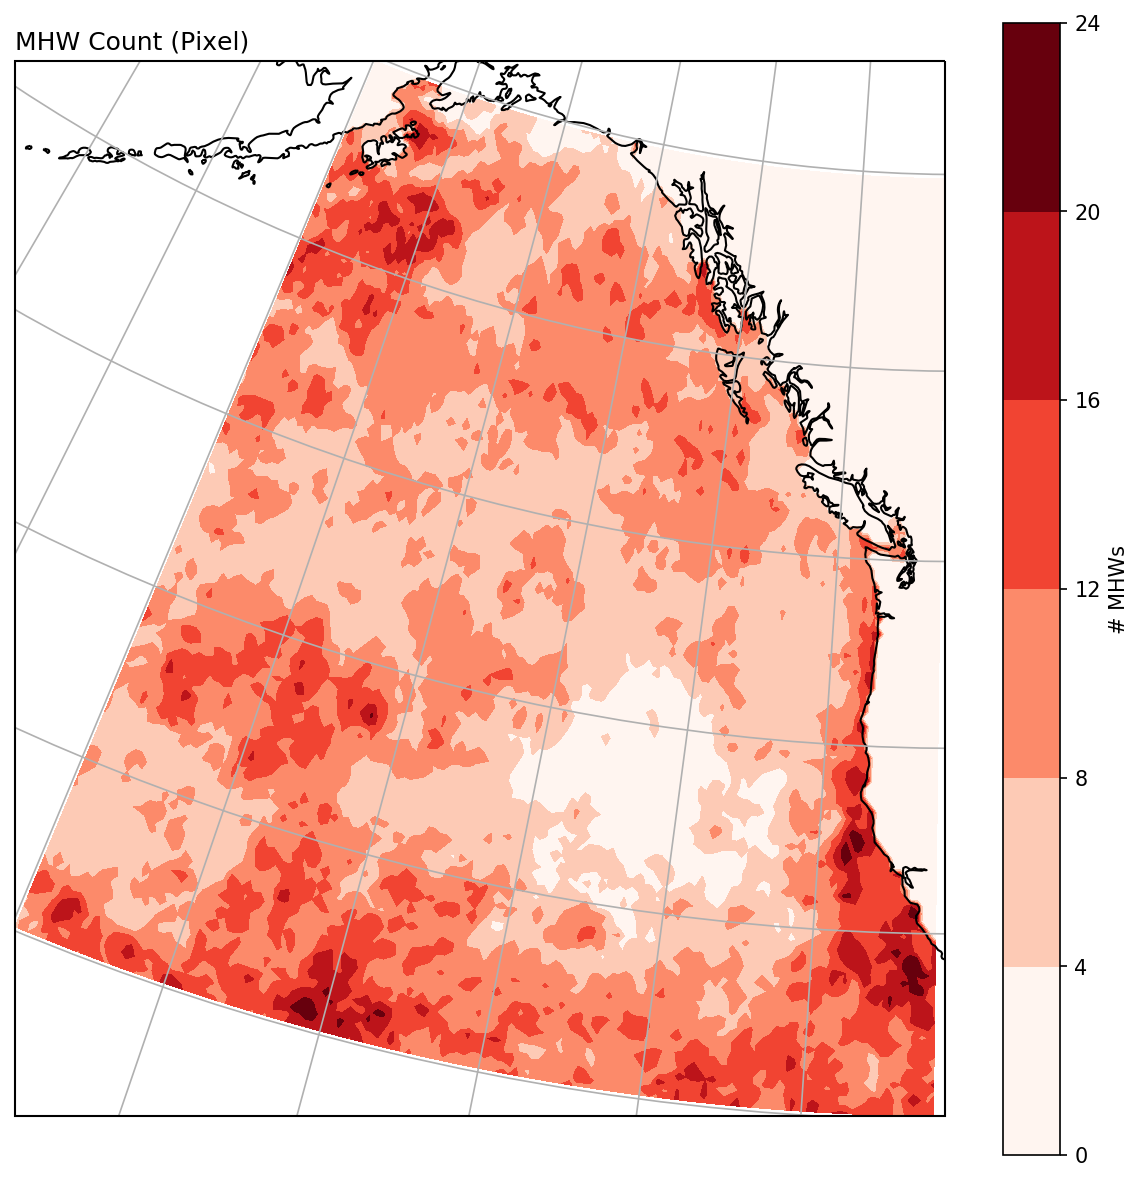

In [8]:
fig = plt.figure(figsize=(10,10), dpi=150)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-120))
decade.mhw.max(dim='time').plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(),
    cbar_kwargs={'label' : "# MHWs"},
    cmap=plt.cm.Reds
)
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k')
ax.set_title("MHW Count (Pixel)", loc='left')
ax.gridlines()

In [30]:
masked = mhws.where(mhws.mhw !=0, drop=True).sel(time=slice('1990', '2018')).mhw.groupby('time.year').count(dim='time')

In [31]:
a = masked.compute()

In [32]:
extent = [
    oisst_pnw.lon.min().values,
    oisst_pnw.lon.max().values,
    oisst_pnw.lat.min().values,
    oisst_pnw.lat.max().values

]

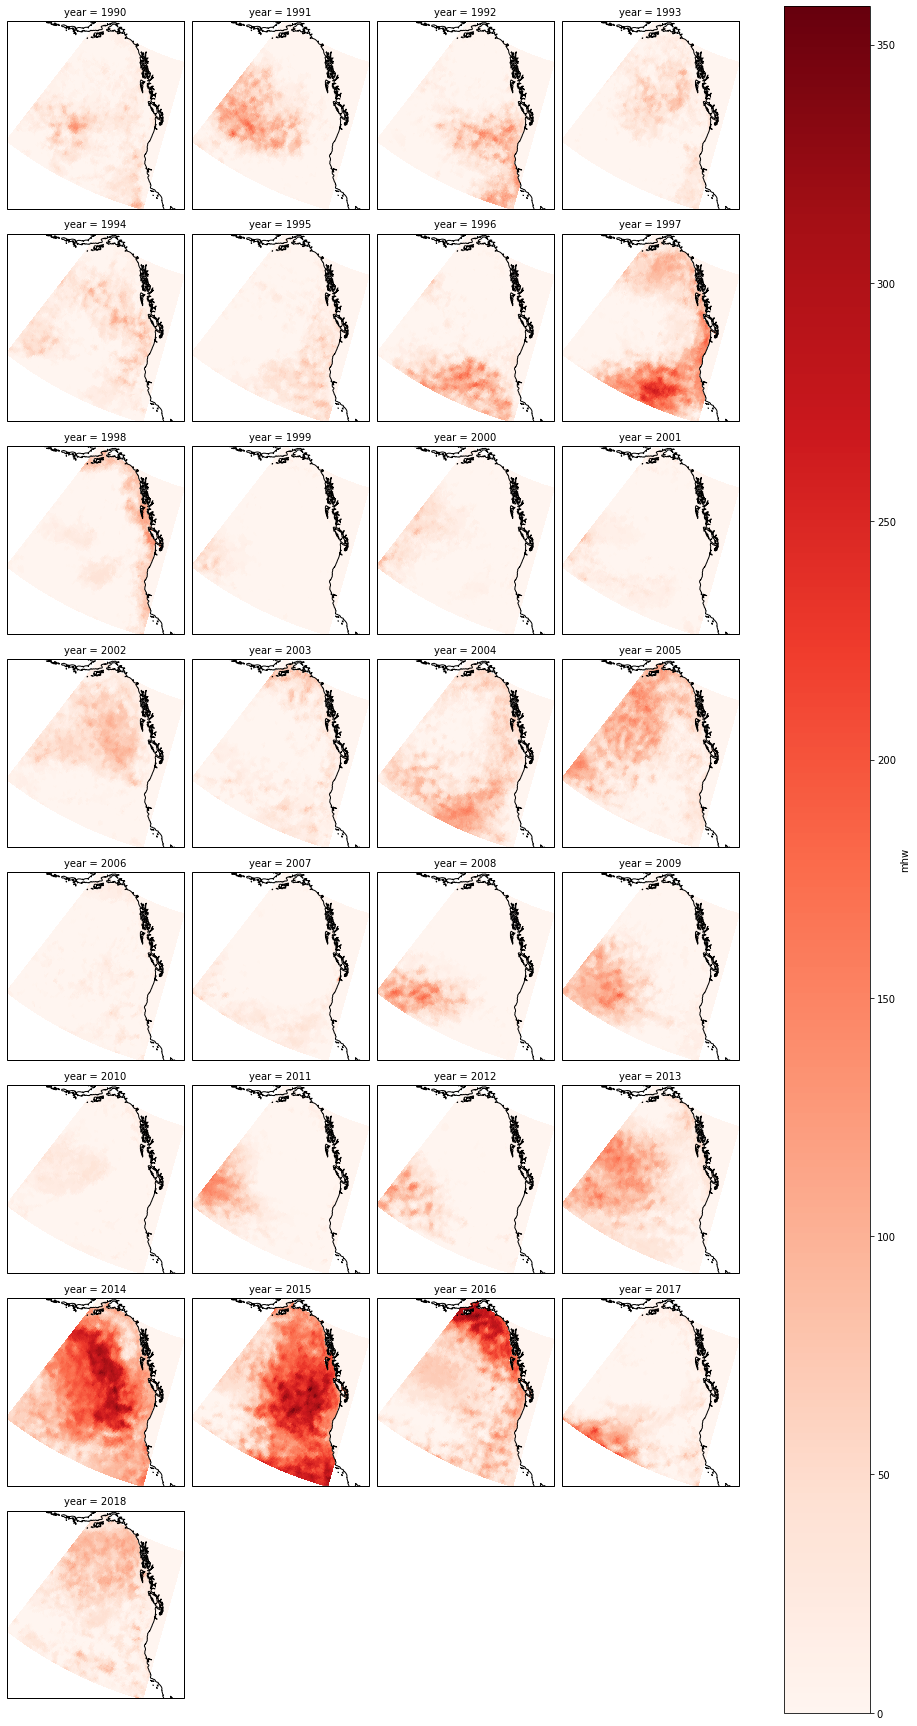

In [36]:
fg = a.plot.pcolormesh(col='year', col_wrap = 4, transform=ccrs.PlateCarree(), cmap='Reds', subplot_kws={'projection': ccrs.LambertConformal()})

list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))
plt.show()

## TPCs?


In [5]:
sys.path.append('../analysis/physiology/')
import tpc

In [6]:
plankton = pd.read_csv('../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv', engine='python')

In [7]:
plankton = plankton[
    (plankton.curvequal == 'good') &
    (plankton.habitat.isin([
        'marine',
    ]))
]
len(plankton)

96

In [8]:
plankton['latqbin'] = pd.cut(plankton['isolation.latitude'], bins=20)
plankton = plankton[plankton.latqbin.isin([mhws.lat.values.max()])]

In [9]:
plankton

isolate.code                              source  isolation.latitude  \
212           299  B�sum harbour, Wadden Sea, Germany               54.12   
230           324                     Northern Baltic               58.88   
456           603                   Hordaland, Norway               60.17   

     isolation.longitude habitat                                         name  \
212                 8.86  marine         Fibrocapsa japonica strain CCRuG-C13   
230                20.32  marine        Gymnodinium corollarium clone GCTV-B4   
456                 5.54  marine  Nannochloropsis oceanica strain CCAP 849/10   

                 speciesname former.name.1 former.name.2       strain  ...  \
212      Fibrocapsa japonica           NaN           NaN    CCRuG-C13  ...   
230  Gymnodinium corollarium           NaN           NaN      GCTV-B4  ...   
456    Nannochloris oceanica           NaN           NaN  CCAP 849/10  ...   

    maxqual curvequal abs.curveskew rel.curveskew used.for.optimum.analysis  \
212    good      good   -132.809926     -0.010578                       1.0   
230    good      good     25.149152      0.012772                       1.0   
456    good      good   -226.648610     -0.014912                       1.0   

    used.for.tmax.analysis used.for.tmin.analysis  \
212                    1.0                    1.0   
230                    1.0                    1.0   
456                    1.0                    1.0   

    used.for.niche.width.analysis used.for.max.growth.rate.analysis  \
212                           1.0                               1.0   
230                           1.0                               1.0   
456                           1.0                               1.0   

              latqbin  
212  (53.614, 61.169]  
230  (53.614, 61.169]  
456  (53.614, 61.169]  

[3 rows x 45 columns]

In [10]:
sample = plankton.sample(1).iloc[0]

In [11]:
sample

isolate.code                                                          299
source                                 B�sum harbour, Wadden Sea, Germany
isolation.latitude                                                  54.12
isolation.longitude                                                  8.86
habitat                                                            marine
name                                 Fibrocapsa japonica strain CCRuG-C13
speciesname                                           Fibrocapsa japonica
former.name.1                                                         NaN
former.name.2                                                         NaN
strain                                                          CCRuG-C13
clone                                                                 NaN
species                                                          japonica
genus                                                          Fibrocapsa
family                                

In [12]:
median_tpc = partial(tpc.tpc, a=sample['mu.alist'], b=sample['mu.blist'], z=sample['mu.c.opt.list'], w=sample['mu.wlist'])

In [161]:
def tpc_1d(temps):
#     if(np.isnan(temps).any()): return np.full_like(temps, fill_value=np.nan)
    nanmasked =  np.ma.array(temps, mask=np.isnan(temps))
    return(median_tpc(nanmasked))
    


In [162]:
tpc = xr.apply_ufunc(
    tpc_1d,
    oisst_pnw.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
)

In [163]:
tpc

<xarray.DataArray 'sst' (lat: 120, lon: 140, time: 13636)>
dask.array<vectorize_tpc_1d, shape=(120, 140, 13636), dtype=float64, chunksize=(5, 5, 13636), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 30.125 30.375 30.625 30.875 ... 59.375 59.625 59.875
  * lon      (lon) float32 -155.875 -155.625 -155.375 ... -121.375 -121.125
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31

In [164]:
ans = tpc.compute()

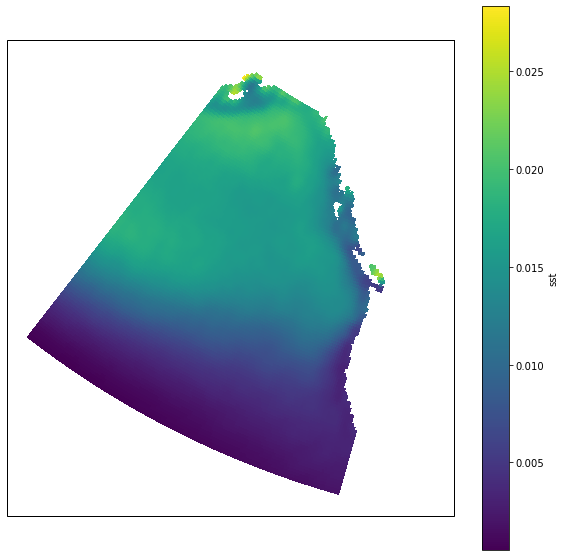

In [165]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.LambertConformal())
ans.var(dim='time').plot(transform=ccrs.PlateCarree(), ax=ax)

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


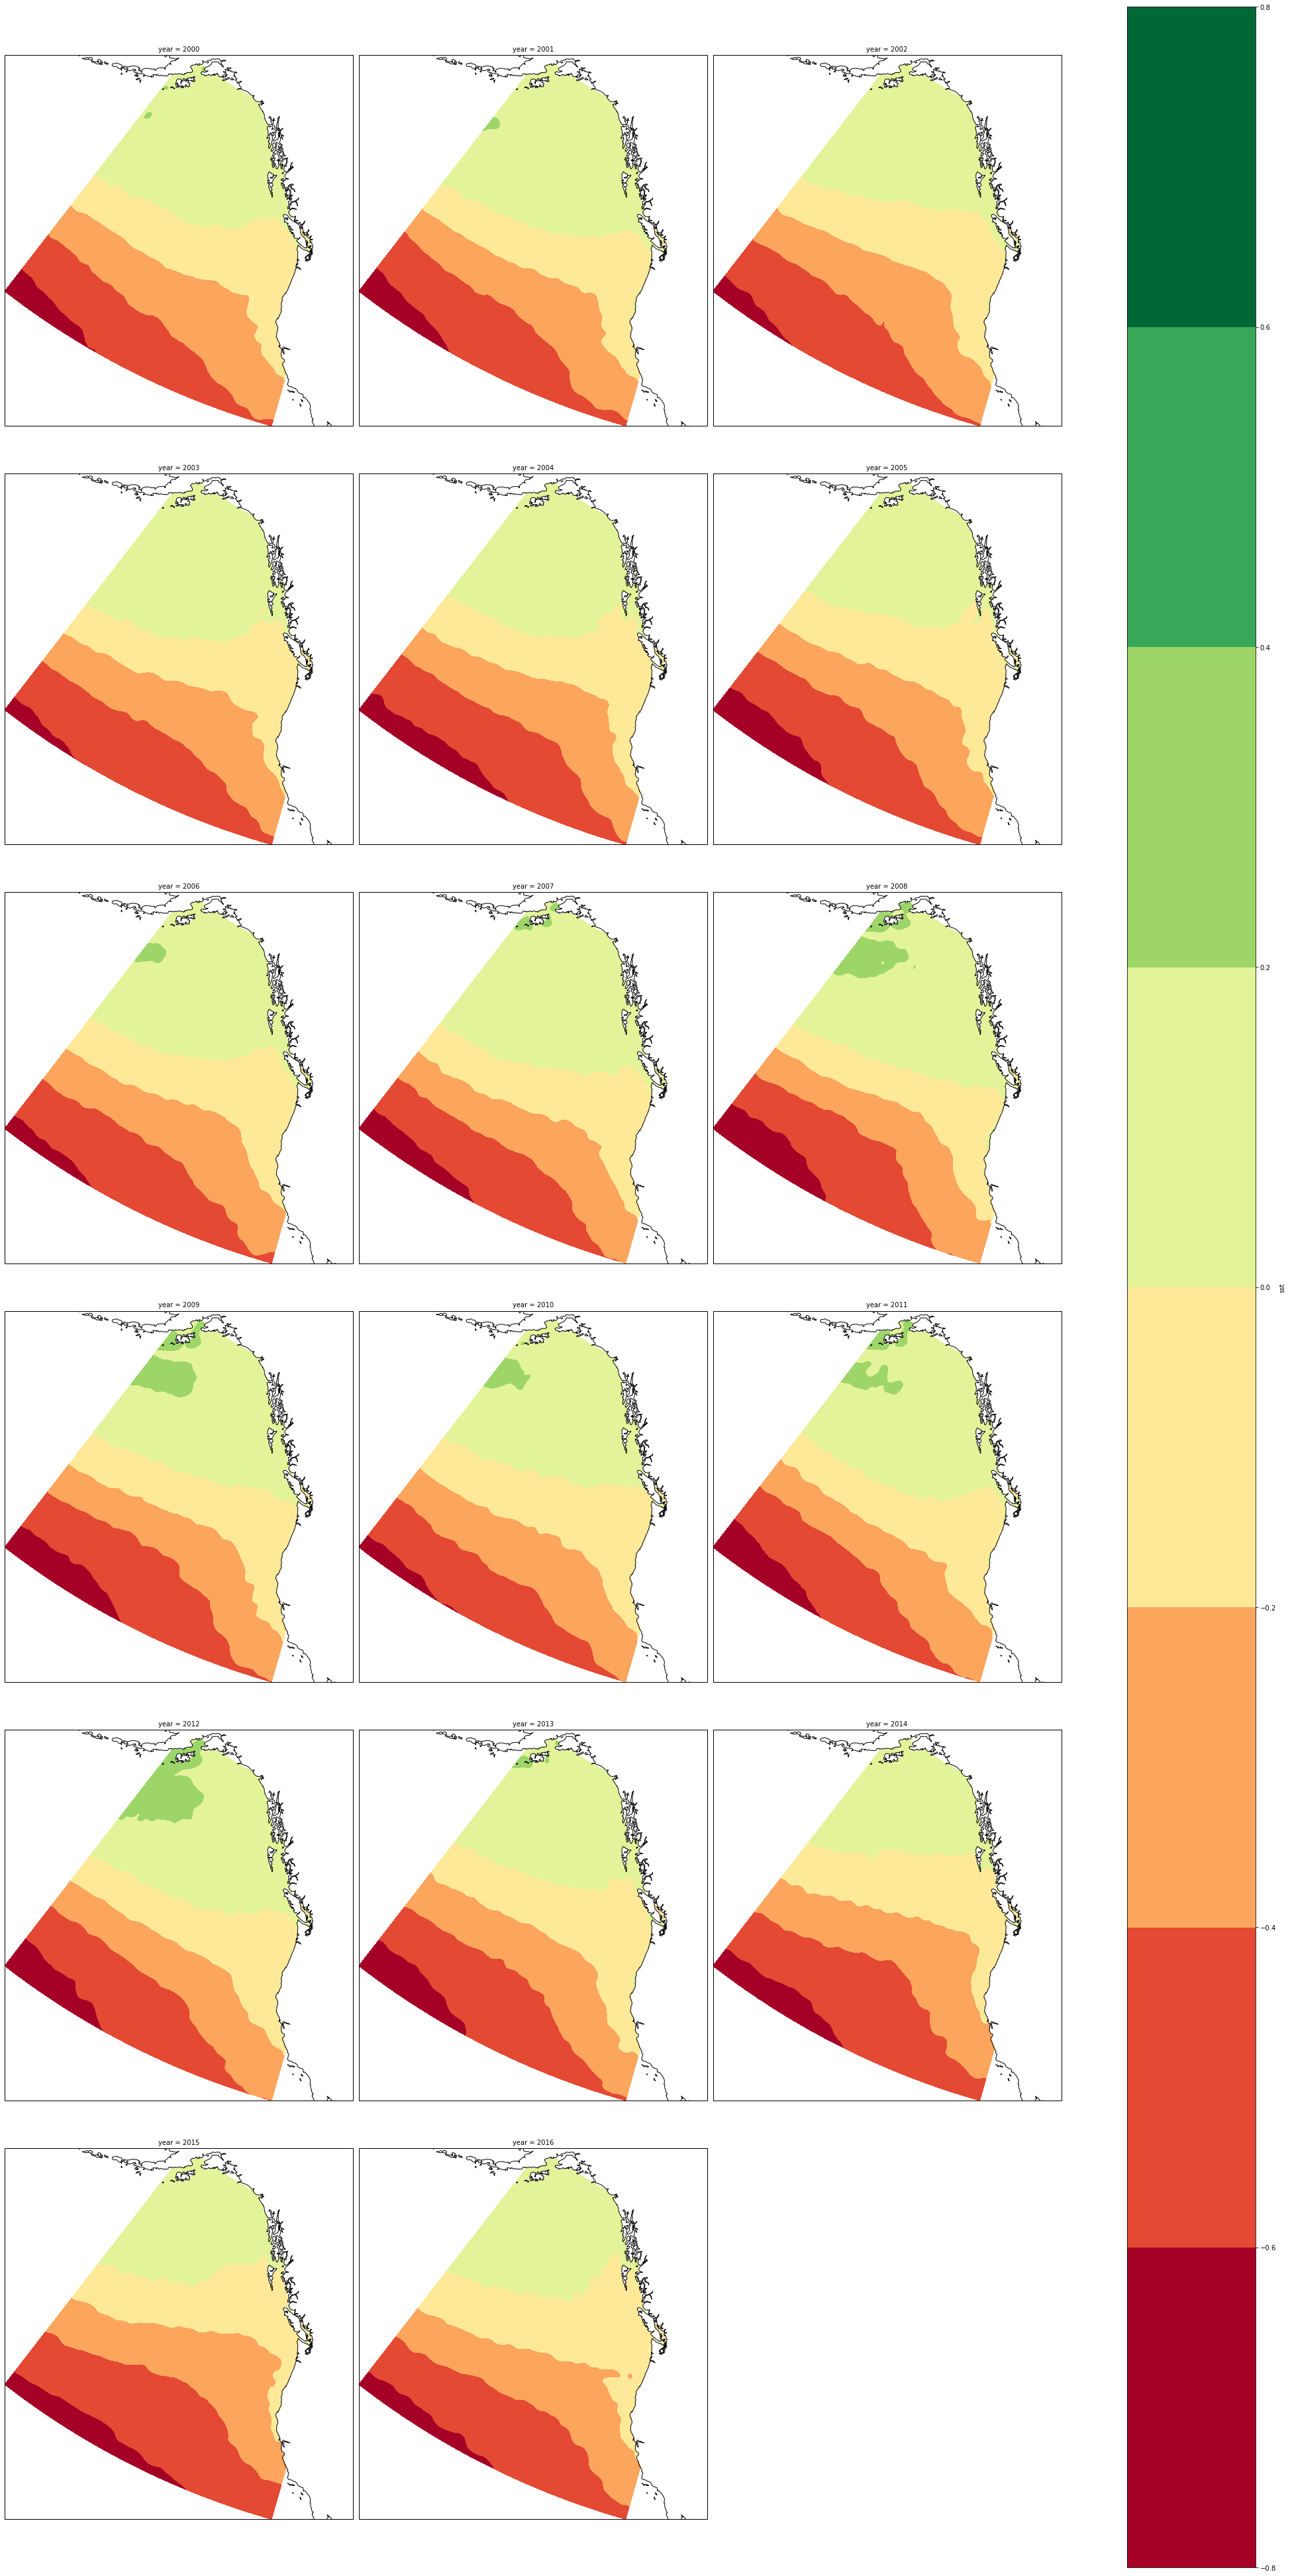

In [109]:


fg = ans.sel(time=slice('2000', '2016')).groupby('time.year').mean(dim='time').plot.contourf(size=9, levels=10, col='year', col_wrap=3, cmap='RdYlGn', transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.LambertConformal()}, )
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


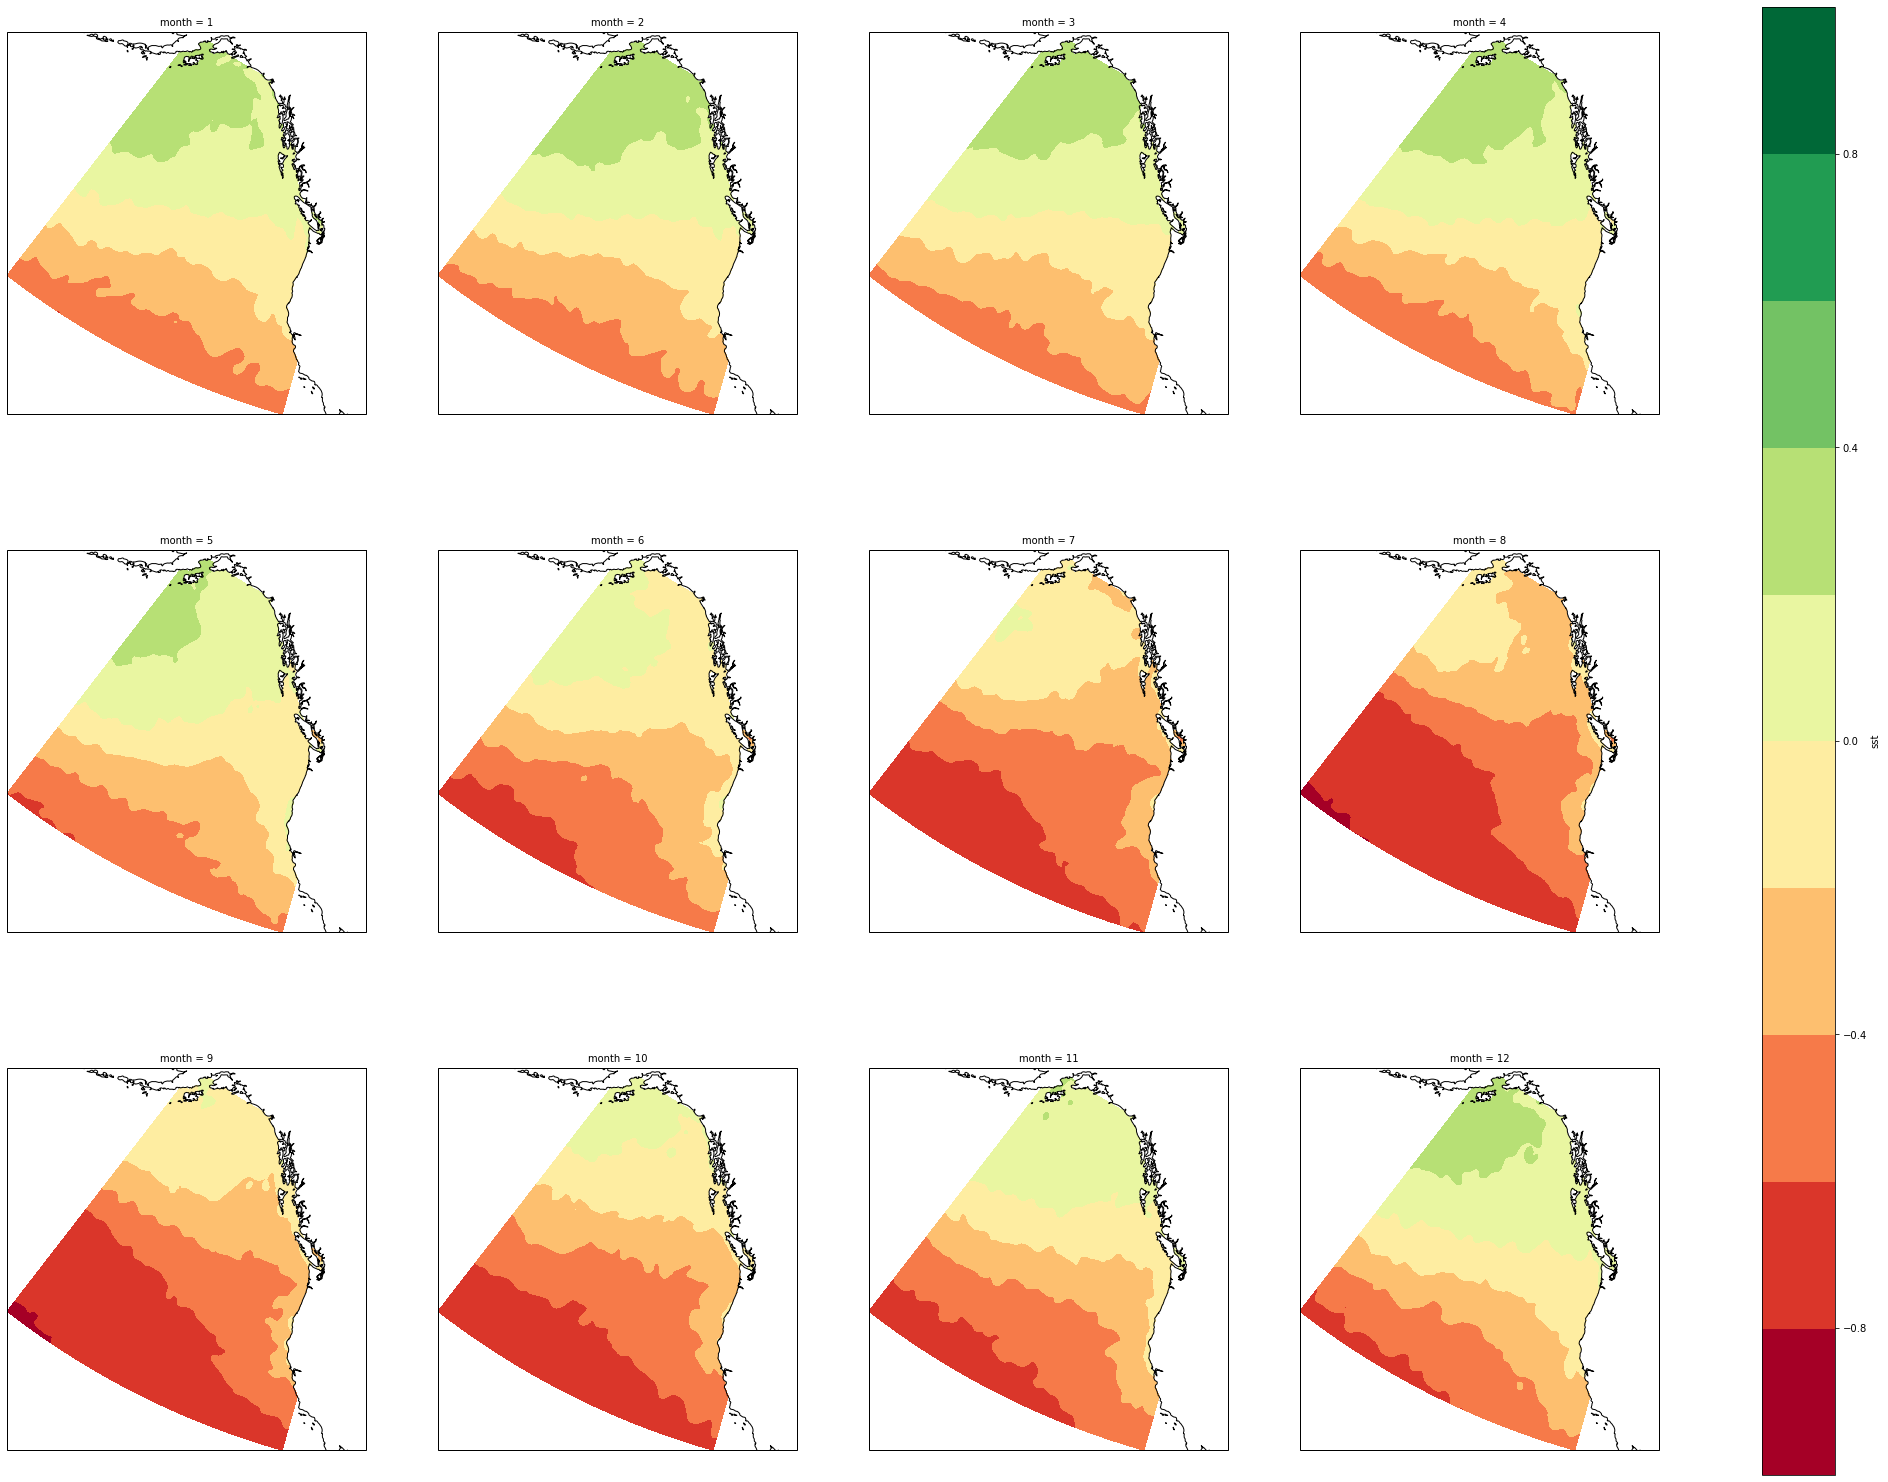

In [110]:


fg = ans.sel(time='2015').groupby('time.month').mean(dim='time').plot.contourf(size=9, levels=10, col='month', col_wrap=4, cmap='RdYlGn', transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.LambertConformal()}, )
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))

# Difference MHW vs nonMHW


In [14]:
mhw_tpc =  ans.sel(time='2015').groupby('time.month').mean(dim='time')
non_mhw_tpc = ans.sel(time='2006').groupby('time.month').mean(dim='time')
diff = mhw_tpc - non_mhw_tpc

NameError: name 'ans' is not defined

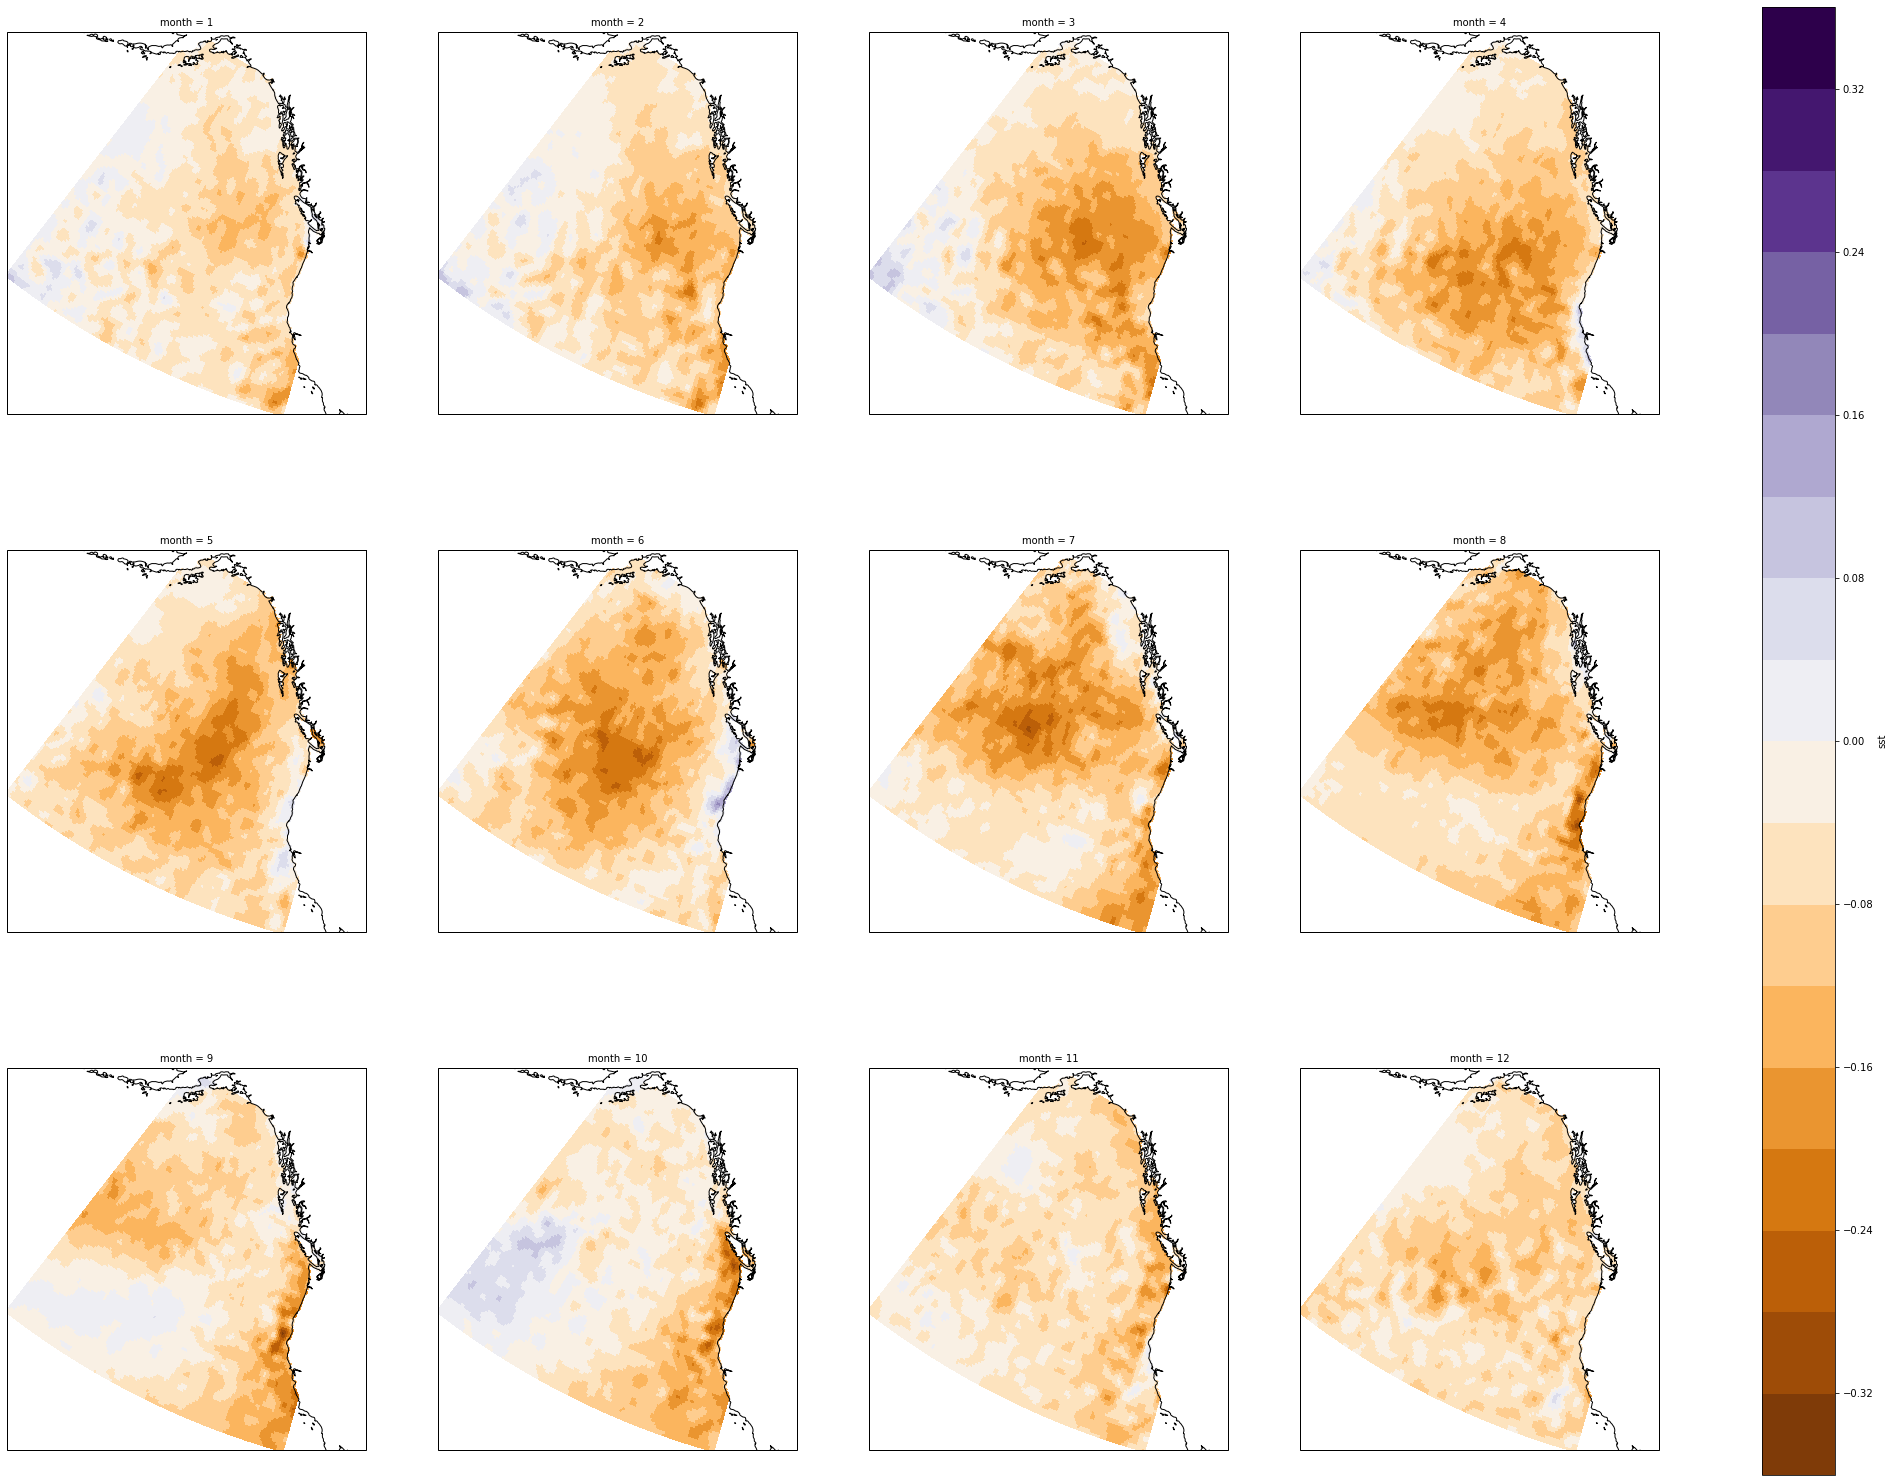

In [112]:


fg = diff.plot.pcolormesh(size=9, levels=20, col='month', col_wrap=4, cmap='PuOr', transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.LambertConformal()}, )
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))

## Use MHW classifications to mask SST data and only compute TPC on relevant pixels

In [ ]:
mhws.duration.plot(bins=100)
plt.xlim([0, 50])
plt.yscale('log')

In [36]:
mhw_only_filter = (mhws.mhw !=0) & (mhws.duration >= 45)
non_mhw_filter = ~(mhws.mhw.notnull())


In [125]:
mhw_only = oisst_pnw.isel(lat=slice(0, 10)).where(mhw_only_filter, drop=True)
non_mhw = oisst_pnw.isel(lat=slice(0,10)).where(~mhw_only_filter)

In [107]:
non_mhw

<xarray.Dataset>
Dimensions:  (lat: 10, lon: 140, time: 13636)
Coordinates:
  * lat      (lat) float64 30.12 30.38 30.62 30.88 ... 31.62 31.88 32.12 32.38
  * lon      (lon) float32 -155.875 -155.625 -155.375 ... -121.375 -121.125
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(500, 10, 100), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    institution:    NOAA/NCDC
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    title:          NOAA High-resolution Blended Analysis: Daily Values using...

Text(0.5, 1.0, 'Lat: [30.125, 32.375], duration: >=45')

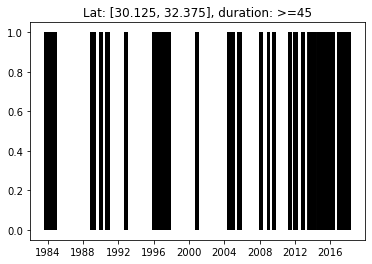

In [109]:
plt.vlines(mhw_only.time.values, ymin=0, ymax=1)
plt.title("Lat: [{}, {}], duration: >={}".format(mhw_only.lat.min().values, mhw_only.lat.max().values, 45))

above plots verify that we're selecting only SST during MHWs as defined above

(732312.0, 733407.0)

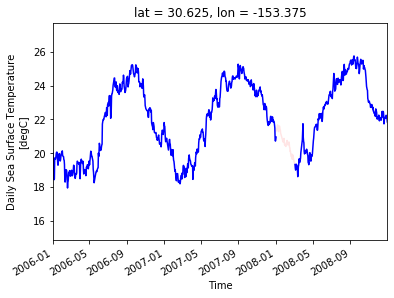

In [128]:
dat = mhw_only.isel(lat=2, lon=10)
dat.sst.plot(color='red',alpha=0.1)
non_mhw.sel(lat=dat.lat, lon=dat.lon).sst.plot(color='blue')
plt.xlim(['2006-01-01', '2008-12-31'])

ok, separation of mhw/non working?


In [166]:
tpc_mhws = xr.apply_ufunc(
    tpc_1d,
    mhw_only.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
)
tpc_non_mhw = xr.apply_ufunc(
    tpc_1d,
    non_mhw.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
)

In [167]:
tpc_mhws = tpc_mhws.compute()
tpc_non_mhw = tpc_non_mhw.compute()

(733773.0, 735963.0)

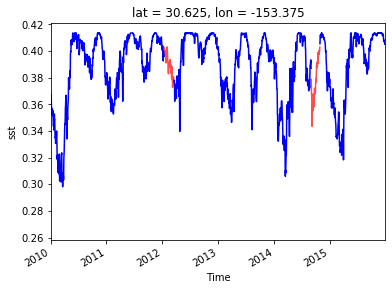

In [175]:
dat = tpc_mhws.isel(lat=2, lon=10)
dat.plot(color='red',alpha=0.7)
tpc_non_mhw.sel(lat=dat.lat, lon=dat.lon).plot(color='blue')
plt.xlim(['2010-01-01', '2015-12-31'])

(732312.0, 733407.0)

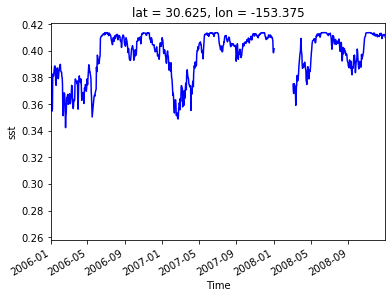

In [169]:
tpc_non_mhw.sel(lat=dat.lat, lon=dat.lon).plot(color='blue')
plt.xlim(['2006-01-01', '2008-12-31'])

In [171]:
tpc_non_mhw

<xarray.DataArray 'sst' (lat: 10, lon: 140, time: 13636)>
array([[[0.3872582 , 0.38334754, 0.38243833, ..., 0.39034295,
         0.39700881, 0.4013266 ],
        [0.38890237, 0.38379654, 0.38243833, ..., 0.38818139,
         0.39616007, 0.40008146],
        [0.38970289, 0.3840197 , 0.3817468 , ..., 0.38575837,
         0.39470279, 0.3990455 ],
        ...,
        [0.34979093, 0.35054407, 0.35129341, ..., 0.32268965,
         0.32528135, 0.32442066],
        [0.3500424 , 0.35079426, 0.35054407, ..., 0.327277  ,
         0.32953602, 0.32756069],
        [0.35376486, 0.35425422, 0.35327384, ..., 0.33121493,
         0.33315676, 0.3292549 ]],

       [[0.38890237, 0.3840197 , 0.38379654, ..., 0.38469002,
         0.39272937, 0.39783815],
        [0.3895041 , 0.38468379, 0.3840197 , ..., 0.38250023,
         0.39226139, 0.39728743],
        [0.3893044 , 0.38468379, 0.38357258, ..., 0.3810015 ,
         0.39131141, 0.39630288],
        ...,
        [0.33644307, 0.33779636, 0.33914006, ..., 0.30593094,
         0.30747035, 0.30593094],
        [0.33644307, 0.33752644, 0.33779636, ..., 0.30991617,
         0.31203869, 0.30900151],
        [0.33887208, 0.34020814, 0.33967486, ..., 0.31444421,
         0.31682789, 0.31022039]],

       [[0.39009783, 0.38468379, 0.38468379, ..., 0.37551531,
         0.38287014, 0.38985169],
        [0.38970289, 0.38490331, 0.38468379, ..., 0.3740862 ,
         0.38175479, 0.39034295],
        [0.3893044 , 0.38533971, 0.38468379, ..., 0.37367374,
         0.3810015 , 0.38885567],
        ...,
        [0.32384512, 0.32613882, 0.32699299, ..., 0.2936458 ,
         0.29460791, 0.29171303],
        [0.32556751, 0.32642394, 0.32528135, ..., 0.2936458 ,
         0.29588643, 0.29041848],
        [0.32784396, 0.32869163, 0.32699299, ..., 0.29652375,
         0.29811165, 0.28911886]],

       ...,

       [[0.39491123, 0.38577232, 0.38334754, ..., 0.3451966 ,
         0.35351956, 0.36346042],
        [0.39420915, 0.38598728, 0.38379654, ..., 0.34597135,
         0.35327384, 0.36414158],
        [0.39438599, 0.38704869, 0.38490331, ..., 0.34750995,
         0.35179099, 0.36254609],
        ...,
        [0.30376196, 0.30438328, 0.29937619, ..., 0.26664782,
         0.2693986 , 0.25758672],
        [0.30747035, 0.30716315, 0.30063573, ..., 0.27110875,
         0.27484632, 0.2617915 ],
        [0.31082785, 0.31173655, 0.30469346, ..., 0.2734912 ,
         0.27854919, 0.26664782]],

       [[0.3969343 , 0.38746685, 0.3844634 , ..., 0.34776506,
         0.35571226, 0.36459357],
        [0.39644012, 0.3876746 , 0.38490331, ..., 0.34852782,
         0.35449827, 0.363915  ],
        [0.39610642, 0.38808739, 0.38598728, ..., 0.34878123,
         0.35302773, 0.36254609],
        ...,
        [0.30531284, 0.30500332, 0.29811165, ..., 0.26109335,
         0.26318446, 0.25013673],
        [0.30991617, 0.31022039, 0.30189005, ..., 0.26422635,
         0.26768145, 0.254408  ],
        [0.32239985, 0.32239985, 0.31022039, ..., 0.2645731 ,
         0.26905575, 0.25617656]],

       [[0.39883408, 0.38910377, 0.38620138, ..., 0.34622872,
         0.35203916, 0.36185578],
        [0.39821443, 0.38890237, 0.38598728, ..., 0.3451966 ,
         0.3502934 , 0.35976169],
        [0.39789954, 0.38869998, 0.38577232, ..., 0.34441841,
         0.34750995, 0.35667607],
        ...,
        [0.30747035, 0.30531284, 0.29620525, ..., 0.2617915 ,
         0.26283661, 0.24977908],
        [0.31948295, 0.31860107, 0.30407277, ..., 0.2617915 ,
         0.26318446, 0.24977908],
        [0.33121493, 0.32953602, 0.31384492, ..., 0.25829017,
         0.26109335, 0.24798715]]])
Coordinates:
  * lat      (lat) float64 30.12 30.38 30.62 30.88 ... 31.62 31.88 32.12 32.38
  * lon      (lon) float32 -155.875 -155.625 -155.375 ... -121.375 -121.125
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31

Not sure how I feel about all that. Perhaps sticking to MHW SST vs climatology. 

In [178]:
tpc_sst = xr.apply_ufunc(
    tpc_1d,
    oisst_pnw.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
).compute()
tpc_climatology = xr.apply_ufunc(
    tpc_1d,
    mhws.clim_seas.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
).compute()

In [182]:
extent = [
    oisst_pnw.lon.min().values,
    oisst_pnw.lon.max().values,
    oisst_pnw.lat.min().values,
    oisst_pnw.lat.max().values

]

In [ ]:
tpc_clim_diff = tpc_sst - tpc_climatology


/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


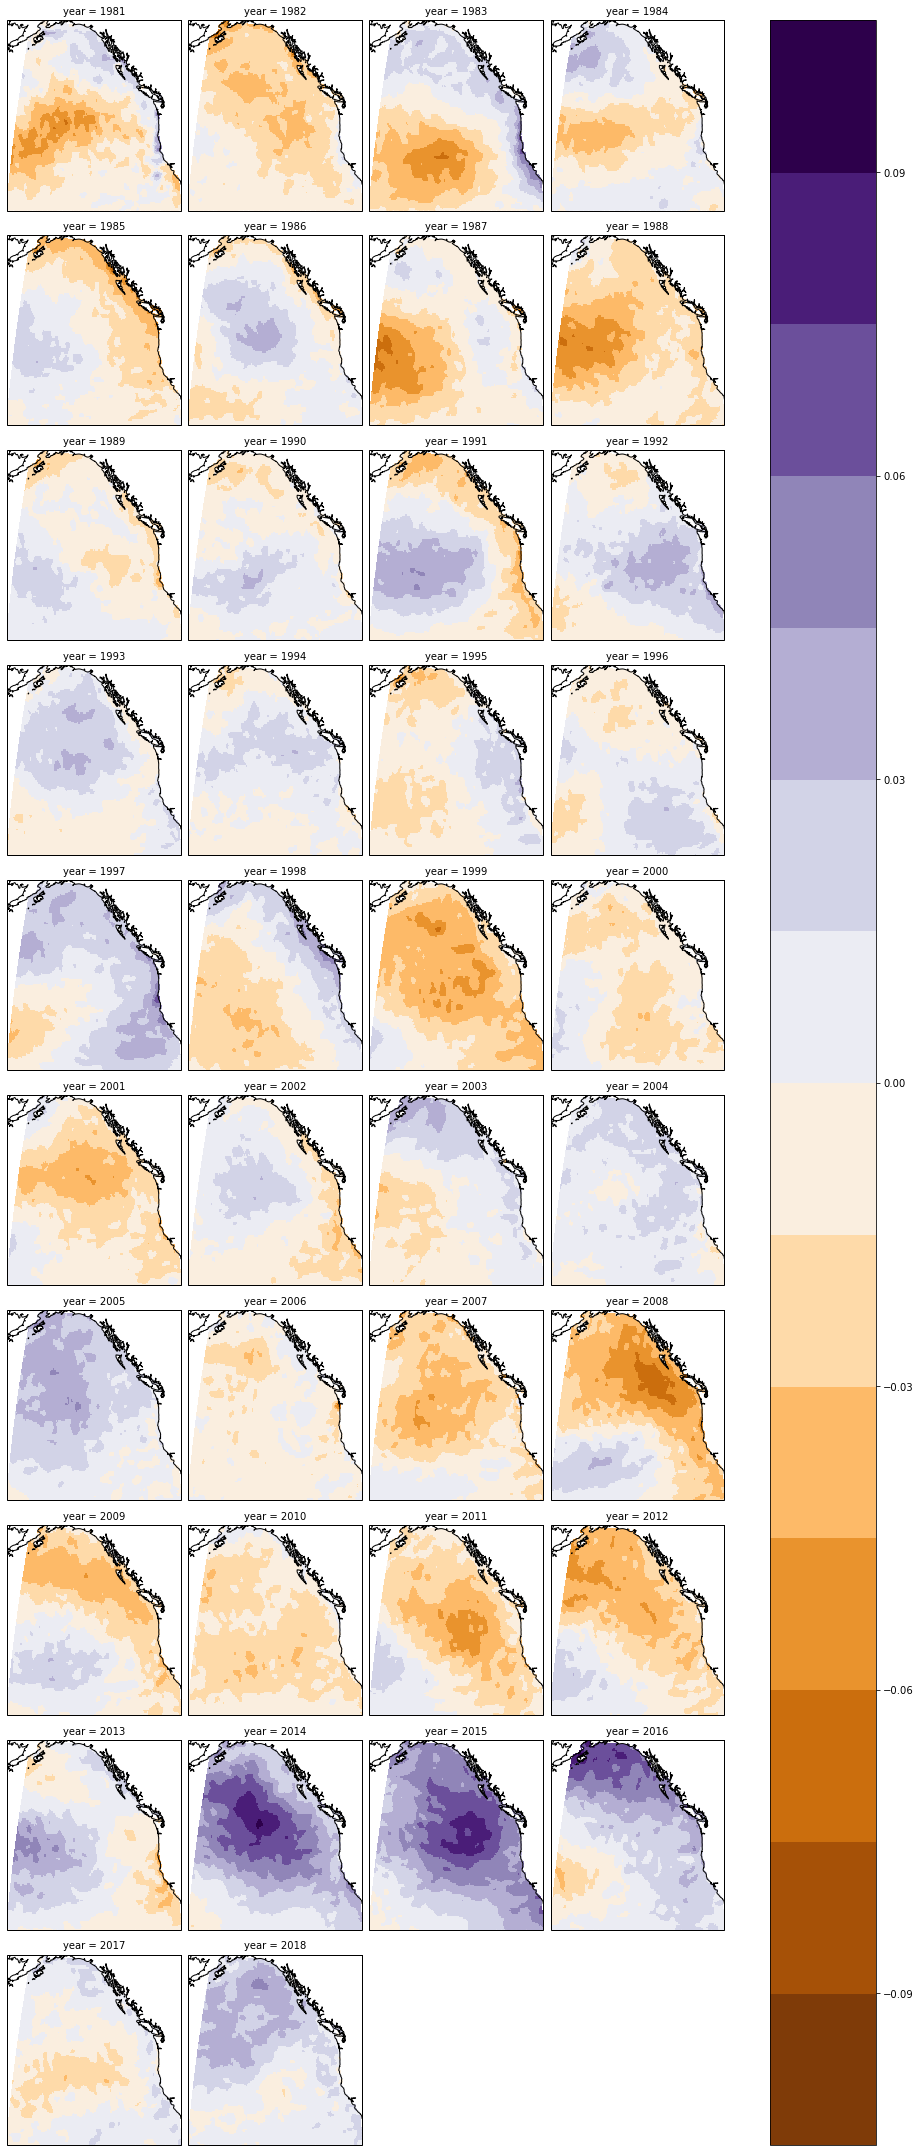

In [219]:


fg = tpc_clim_diff.groupby('time.year').mean(dim='time').plot.pcolormesh(size=3, levels=20, col='year', col_wrap=4, cmap='PuOr', transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.Stereographic(central_longitude=-138)}, )
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))


/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'cbar_kws'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


Text(0.5, 0.98, '2015')

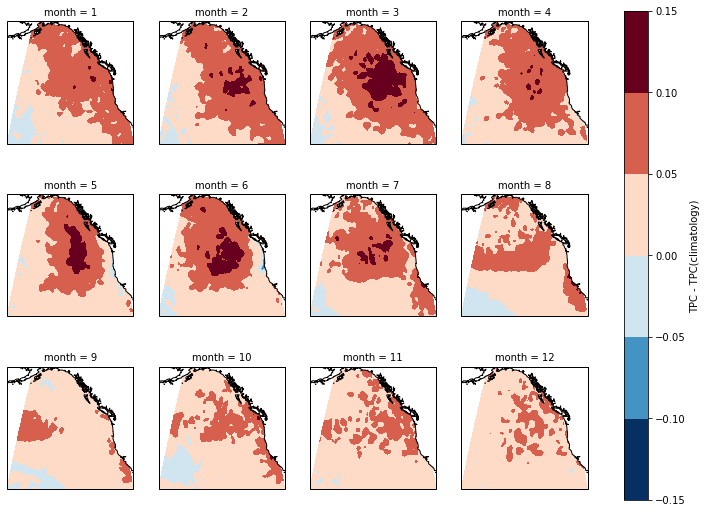

In [220]:
fg = tpc_clim_diff.sel(time='2015').groupby('time.month').mean(dim='time').plot.contourf(
    col='month', col_wrap=4, size=3, 
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.Stereographic(central_longitude=-138, central_latitude=45)},
    cbar_kws={'label': "TPC difference from TPC(climatology)"}
)
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))
fg.cbar.set_label("TPC - TPC(climatology)")

fig.suptitle("2015")

Text(0.5, 0.98, '2006')

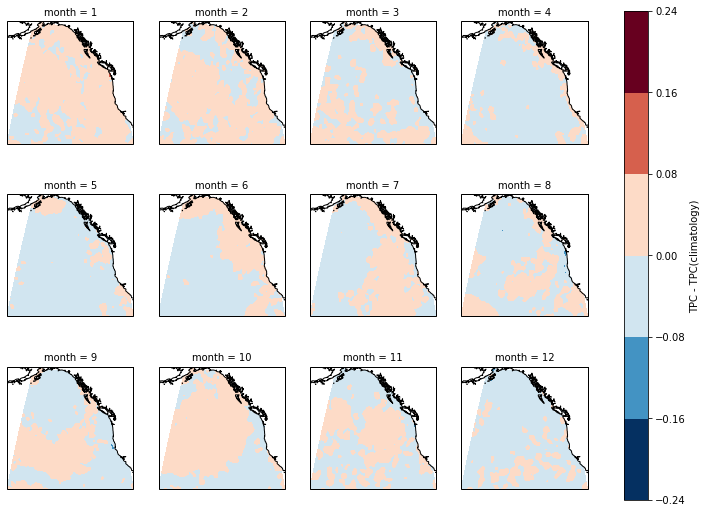

In [222]:
fg = tpc_clim_diff.sel(time='2006').groupby('time.month').mean(dim='time').plot.contourf(
    col='month', col_wrap=4, size=3, 
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.Stereographic(central_longitude=-138, central_latitude=45)},
)
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))
fg.cbar.set_label("TPC - TPC(climatology)")
fig.suptitle('2006')

In [214]:
fg.cbar.set_label("TPC - TPC(climatology)")